In [ ]:
# Install Software and check its version
! pip install -q 'gwosc==0.5.4'
import gwosc
print(gwosc.__version__)

# #Uncomment this section to install everything once 

# ! pip install -q 'lalsuite==6.82' 'PyCBC==1.18.0' 'gwpy==2.0.2'
# ! pip install matplotlib==3.1.3
# # -- Click "restart runtime" in the runtime menu after recommenting all this

0.5.4


In [ ]:
 # Import all needed librairies and methods
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pylab

import pycbc.types 
from pycbc.types import TimeSeries

import pycbc.noise

import pycbc.psd
from pycbc.psd import interpolate, inverse_spectrum_truncation

import pycbc.filter
from pycbc.filter import resample_to_delta_t, highpass, matched_filter

import pycbc.waveform
from pycbc.waveform import get_td_waveform

In [ ]:
### Loading Data ###
#--> from google doc sheet of assignment


# -- download data
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf

# -- for gwpy 
from gwpy.timeseries import TimeSeries
gwpy_strain = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")

# -- for pycbc
from pycbc import frame
pycbc_strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')


--2022-02-14 13:28:23--  https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4025842 (3.8M)
Saving to: ‘challenge2.gwf’

challenge2.gwf      100%[===================>]   3.84M  6.16MB/s    in 0.6s    

2022-02-14 13:28:24 (6.16 MB/s) - ‘challenge2.gwf’ saved [4025842/4025842]



1) What is the approximative time of the merger? (Hint: a plot of the q-transform could help)


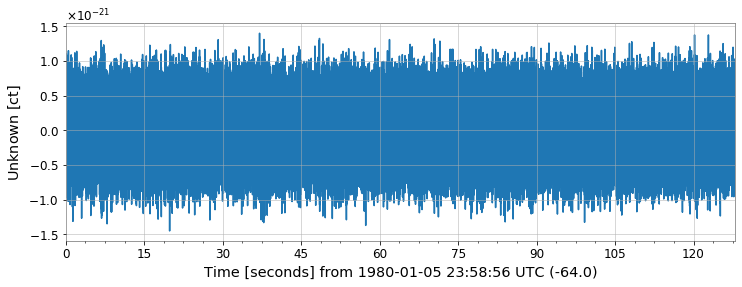

In [ ]:
#first look at what the plot looks like
plot = gwpy_strain.plot()


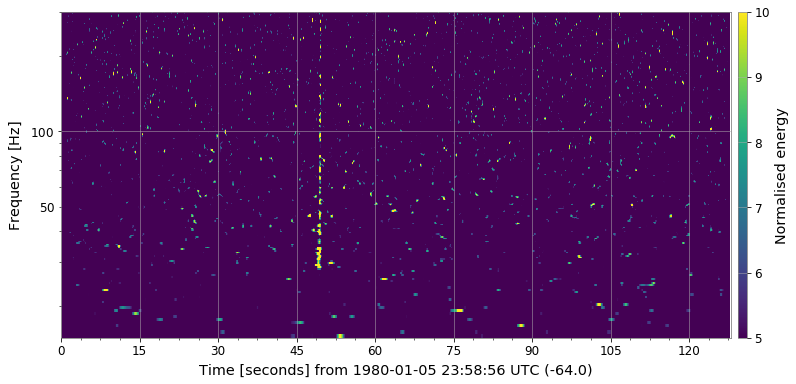

In [ ]:
#apply q-transform and plot graph
Qgwpy_strain = gwpy_strain.q_transform(frange=(15, 300), qrange=(100, 120))
plot = Qgwpy_strain.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")
plot.colorbars[0].mappable.set_clim(5,10)
plot.refresh()


In [ ]:
## as in challenge one, we can see the merger on the graph. Hence, the approximate time of the merger is 49 seconds.

2) Generate a time-domain template waveform using approximate "SEOBNRv4_opt". with the same parameters as above. Plot this waveform.

In [ ]:
#initialize the sample rate
sample_rate = 1024 # samples per second

#set the approximate
apx = 'SEOBNRv4_opt'

In [ ]:
#create the template
hp, _ = get_td_waveform(approximant=apx,
                         mass1=30,
                         mass2=30,
                         delta_t=1.0/sample_rate,
                         f_lower=25)

Text(0, 0.5, 'Normalized amplitude')

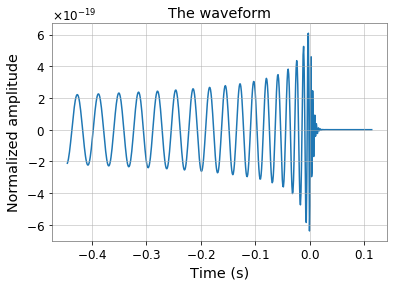

In [ ]:
#plot the waveform
pylab.figure()
pylab.title("The waveform")
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')


3) Calculate a PSD of the data, and plot this on a log-log scale. Use axes ranging from 20 Hz up to the Nyquist frequency.


Sample rate:  4096.0 1 / s
Nyquist frequency:  2048.0 1 / s


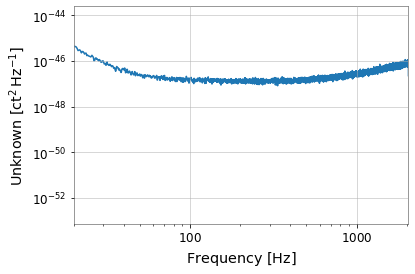

In [ ]:
# compute PSD
psd = gwpy_strain.psd(4)


sample_rate = 1/(gwpy_strain.dt) # get TimeSeries.dt inversely to find sample rate
nyq_freq = sample_rate/2 # Nyquist frequency = sampling rate /2

#print sample rate and Nyquist frequencies to know their values
print("Sample rate: ", sample_rate)
print("Nyquist frequency: ", nyq_freq)
# Plotting
plot = psd.plot()
ax = plot.gca()

#range (20, Nyquist freq)
ax.set_xlim(20, 2048)

#get log scale
ax.set_yscale('log')
ax.set_xscale('log')


4) Use the template waveform and PSD to calculate the SNR time series. Plot the SNR time-series.

In [ ]:
pycbc_strain 

In [ ]:
# Remove the low frequency content and downsample the data to 2048Hz

pycbc_strain = highpass(pycbc_strain, 15.0)
pycbc_strain = resample_to_delta_t(pycbc_strain, 1.0/2048)

# Condition data = Remove 2 seconds of data from both the beginning and end 
conditioned_strain = pycbc_strain.crop(2,2)



In [ ]:
# dir(pycbc_strain.delta_f)

In [ ]:
# help(interpolate)

In [ ]:
#create new template
m=30 #solar masses
hp, _ = get_td_waveform(approximant=apx,
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned_strain.delta_t,
                     f_lower=25)

# Resize the vector to match our data
hp.resize(len(conditioned_strain))

In [ ]:
#shift the template
template = hp.cyclic_time_shift(hp.start_time)


#compute PSD and work it out
psd = conditioned_strain.psd(4)

psd = interpolate(psd, conditioned_strain.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * pycbc_strain.sample_rate),
                                  low_frequency_cutoff=15)

In [ ]:
# pylab.plot(hp.sample_times, hp)

Text(0, 0.5, 'Strain')

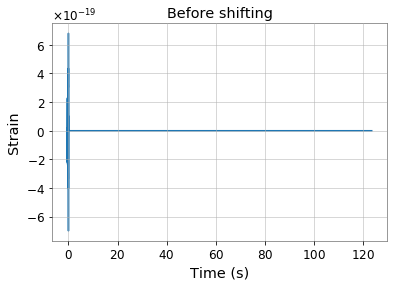

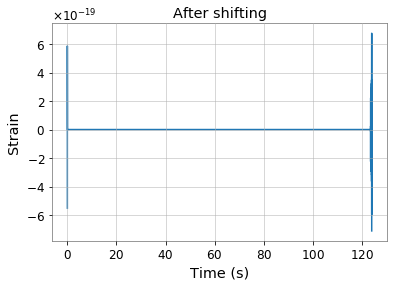

In [ ]:
# Let's plot the signal before and after shifting
#this will allow us to see better what is happening

pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

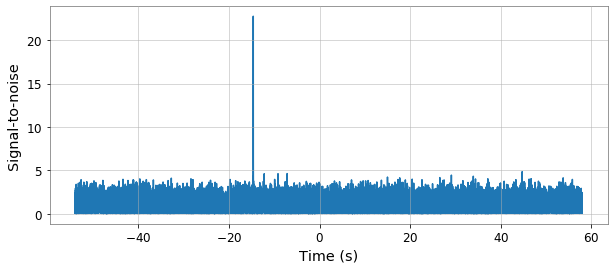

We found a signal at -14.6328125s with SNR 22.746236711285057


In [ ]:
# Plot the SNR time-series
#(code from tutorial)
snr = matched_filter(template, 
                     conditioned_strain,
                     psd=psd, 
                     low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax() # find the peak (its location in the array)
snrp = snr[peak] # get its SNR value
time = snr.sample_times[peak] # get its location (in time)

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

5) What is the matched filter SNR of the signal?

In [ ]:
#the answer is written right above (SNR = 22.746236711285057)